In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

### Exploring the Dataset

In [3]:
df = pd.read_csv('data.csv') # importing the data

In [4]:
df.describe() # getting the summary of the data

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
count,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000
mean,306.381356,3.727754,4.325212,2.939619,5.394068,2.842161,47.043432,4.565678,16.331568,0.416314
std,1082.606745,2.677235,1.438436,1.383725,1.269349,2.273337,16.423130,1.599287,5.974781,0.493208
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,19.000000,1.000000,1.000000,0.000000
25%,1.000000,1.000000,3.000000,2.000000,5.000000,1.000000,34.000000,3.000000,14.000000,0.000000
50%,22.000000,3.000000,4.000000,3.000000,6.000000,2.000000,44.000000,4.000000,17.000000,0.000000
75%,110.000000,7.000000,6.000000,4.000000,6.000000,5.000000,58.000000,6.000000,21.000000,1.000000
max,7300.000000,7.000000,7.000000,7.000000,7.000000,6.000000,91.000000,7.000000,24.000000,1.000000


In [5]:
df.info() # getting the information of the data regarding the data types of features, number of non-null values, etc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944 entries, 0 to 943
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   footfall     944 non-null    int64
 1   tempMode     944 non-null    int64
 2   AQ           944 non-null    int64
 3   USS          944 non-null    int64
 4   CS           944 non-null    int64
 5   VOC          944 non-null    int64
 6   RP           944 non-null    int64
 7   IP           944 non-null    int64
 8   Temperature  944 non-null    int64
 9   fail         944 non-null    int64
dtypes: int64(10)
memory usage: 73.9 KB


In [6]:
df.duplicated().sum() # checking for the number of duplicate rows in the data

1

In [7]:
df.head() # getting the first 5 rows of the data

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
0,0,7,7,1,6,6,36,3,1,1
1,190,1,3,3,5,1,20,4,1,0
2,31,7,2,2,6,1,24,6,1,0
3,83,4,3,4,5,1,28,6,1,0
4,640,7,5,6,4,0,68,6,1,0


My initial impressions of the dataset:

* There are 944 total rows, with 1 duplicated row.
* All data is in numeric form, so there isn't much data pre-processing needed.
* There are no missing values.

In [8]:
df.drop_duplicates(inplace=True) # dropping the duplicate rows

### Checking Skewness of Dataset

Checking if the dataset is imbalanced and skewed in any way

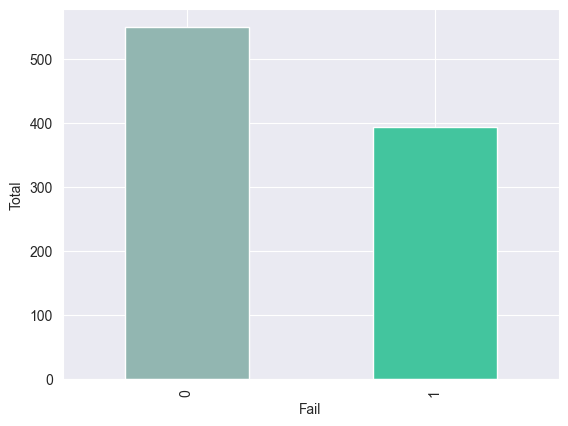

In [9]:
color = ['#92B6B1', '#43C59E'] # defining the colors for the plots
sns.set_style('darkgrid') # setting the style for the plot
df['fail'].value_counts().plot.bar(color=color) # plotting the bar plot for the target variable
plt.xlabel('Fail') # setting the x-axis label
plt.ylabel('Total') # setting the y-axis label
plt.show()

It looks like the data is skewed, as the count of positive examples are lower than the negative examples. I will use SMOTE, an over sampling technique to increase the count of positive examples to make the distribution a little better.

### Over sampling to decrease Skewness

In [11]:
over_sampler = SMOTE(random_state=42) # initializing the SMOTE object
X = df.drop(['fail'], axis=1) # seperating the features from the target feature
y = df['fail'] # isolating the target feature
X, y = over_sampler.fit_resample(X, y) # resampling the dataset

<Axes: xlabel='fail'>

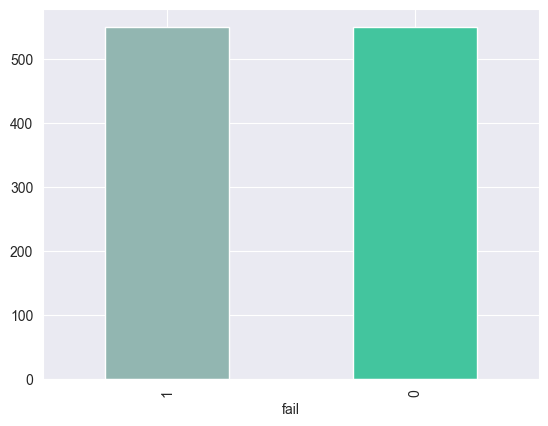

In [12]:
y.value_counts().plot.bar(color=color) # plotting the bar plot for the target variable after resampling

As you can see, the count of positive and negative examples is much better. Now I will scale the dataset and then train a model.

### Feature Scaling

I will use a min-max scaler, it will scale the values of features to a value between the range 0 and 1.

In [13]:
scaler = MinMaxScaler() # Initializing the MinMaxScaler
X_scaled = scaler.fit_transform(X) # scaling the data

### Data Splitting

Next, we will split the data into Test and Train sets. This is an important step. You want a way to evaluate the model, and splitting the data into Train and Test sets gives you that option. Usually, you also would want to split the Test set further into Cross-validation and Test sets, and use the Cross-validation set for hyperparameter tuning. I used that approach to tune the hyperparameters, and now that I have finalized the values for hyperparameters, I will skip splitting the data further into cross-validation set and test set, and just directly split the data into Training and Test sets. I will do a 70:30 split on the dataset.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42) # splitting the data into training and testing sets

### Model Training

I will be training a regularized logistic regression model. I will implement everything from scratch, using just numpy and maths. The functions for gradient descent and others are defined below.

In [27]:
def compute_cost(w, b, X, y, lambda_reg):
    '''
    Compute the cost function for logistic regression
    
    Parameters:
        w (numpy array): weight parameters of the model
        b (float): bias parameter of the model
        X (numpy array): features of the dataset excluding the target feature
        y (numpy array): target feature of the dataset
        lambda_reg (int): regularization parameter
    
    Returns:
        cost (float): the cost of the model with respect to the current weights and bias
    '''
    m = X.shape[0] # getting the number of examples in the dataset
    z = np.dot(X, w) + b # computing the linear combination of the weights and features
    f_wb = 1/(np.exp(-z) + 1) # applying the sigmoid function to the linear combination
    cost = (-1/m) * np.sum(y * np.log(f_wb) + (1-y) * np.log(1-f_wb)) + (lambda_reg/(2*m) * np.sum(w**2)) # computing the cost function
    return cost


def gradient_descent(w, b, X, y, lambda_reg):
    '''
    Compute the derivatives of the cost function with respect to the weights and bias.
    
    Parameters:
        w (numpy array): weight parameters of the model
        b (float): bias parameter of the model
        X (numpy array): features of the dataset excluding the target feature
        y (numpy array): target feature of the dataset
        lambda_reg (int): regularization parameter
    
    Returns:
        dj_dw (numpy array): the value of the derivative of the cost function with respect to the weights
        dj_db (float): the value of the derivative of the cost function with respect to the bias
    '''
    m, n = X.shape # getting the number of examples and features in the dataset
    z = np.dot(X, w) + b # computing the linear combination of the weights and features
    f_wb = 1/(np.exp(-z) + 1) # applying the sigmoid function to the linear combination
    err = f_wb - y  # computing the error term
    dj_dw = (1/m) * np.dot(X.T, err) + (lambda_reg/m) * w # computing the derivative of the cost function with respect to the weights, and adding the regularization term
    dj_db = (1/m) * np.sum(err) # computing the derivative of the cost function with respect to the bias. Since I am only regularizing the weights, I will skip adding the regularization term to the bias. Although, that is an option that you can implement
    return dj_dw, dj_db


def compute_GD(w, b, X, y, epochs, alpha, lambda_reg, stopping_criteria=0.00001):
    '''
    Apply gradient descent to find the optimal weights and bias for the logistic regression model.
    
    Parameters:
        w (numpy array): weight parameters of the model
        b (float): bias parameter of the model
        X (numpy array): features of the dataset excluding the target feature
        y (numpy array): target feature of the dataset
        epochs (int): number of iterations to run the gradient descent algorithm
        alpha (float): learning rate
        lambda_reg (int): regularization parameter
        stopping_criteria (float): the difference between the cost of the current iteration and the previous iteration to stop the algorithm
    
    Returns:
        w (numpy array): the optimal weight parameters of the model
        b (float): the optimal bias parameter of the model
        JD_history (list): the cost of the model at each iteration for visualization purposes
    '''
    JD_history = [] # initializing the list to store the cost of the model at each iteration, for visualization purposes
    
    for i in range(epochs): # looping through the number of iterations
        dj_dw, dj_db = gradient_descent(w, b, X, y, lambda_reg) # computing the derivatives of the cost function with respect to the weights and bias
        w = w - alpha * dj_dw # updating the weights
        b = b - alpha * dj_db # updating the bias
        
        if i<100000: # storing the cost of the model at each iteration
            JD_history.append(compute_cost(w, b, X, y, lambda_reg)) # computing the cost of the model at each iteration
        
        if i% math.ceil(epochs/100) == 0: # printing the cost of the model at every 100th iterations
            print("Epoch:{:4}, Loss:{:4.2f}".format(i, JD_history[-1])) # printing the cost and iteration number
        
        if i>1 and abs(JD_history[-1] - JD_history[-2]) < stopping_criteria: # checking if the difference between the cost of the current iteration and the previous iteration is less than the stopping criteria
            break
    
    return w, b, JD_history

In [28]:
# Defining the hyperparameters

epochs = 10000 # number of iterations
alpha = 0.01 # learning rate
lambda_reg = 1 # regularization parameter

w = np.zeros(X_train.shape[1]) # initializing the weights
b = 0 # initializing the bias

w, b, JD_history = compute_GD(w, b, X_train, y_train, epochs, alpha, lambda_reg) # training the model

Epoch:   0, Loss:0.69
Epoch: 100, Loss:0.66
Epoch: 200, Loss:0.64
Epoch: 300, Loss:0.62
Epoch: 400, Loss:0.60
Epoch: 500, Loss:0.58
Epoch: 600, Loss:0.56
Epoch: 700, Loss:0.55
Epoch: 800, Loss:0.53
Epoch: 900, Loss:0.52
Epoch:1000, Loss:0.51
Epoch:1100, Loss:0.50
Epoch:1200, Loss:0.49
Epoch:1300, Loss:0.47
Epoch:1400, Loss:0.47
Epoch:1500, Loss:0.46
Epoch:1600, Loss:0.45
Epoch:1700, Loss:0.44
Epoch:1800, Loss:0.43
Epoch:1900, Loss:0.43
Epoch:2000, Loss:0.42
Epoch:2100, Loss:0.41
Epoch:2200, Loss:0.41
Epoch:2300, Loss:0.40
Epoch:2400, Loss:0.40
Epoch:2500, Loss:0.39
Epoch:2600, Loss:0.39
Epoch:2700, Loss:0.38
Epoch:2800, Loss:0.38
Epoch:2900, Loss:0.38
Epoch:3000, Loss:0.37
Epoch:3100, Loss:0.37
Epoch:3200, Loss:0.37
Epoch:3300, Loss:0.36
Epoch:3400, Loss:0.36
Epoch:3500, Loss:0.36
Epoch:3600, Loss:0.35
Epoch:3700, Loss:0.35
Epoch:3800, Loss:0.35
Epoch:3900, Loss:0.35
Epoch:4000, Loss:0.34
Epoch:4100, Loss:0.34
Epoch:4200, Loss:0.34
Epoch:4300, Loss:0.34
Epoch:4400, Loss:0.34
Epoch:4500

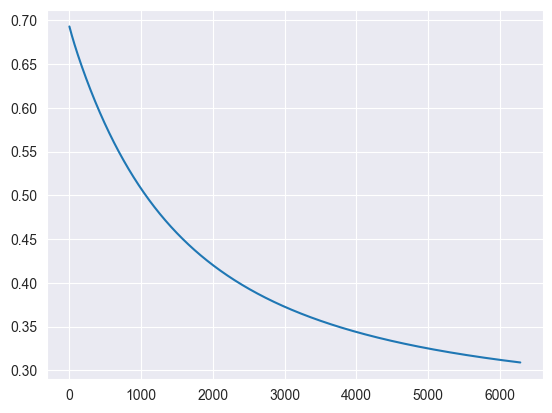

In [25]:
plt.plot(JD_history) # plotting the cost of the model at each iteration

The loss seems to be decreasing at a decent pace, there are no signs that we are shooting over the global optimum (as the loss is constantly decreasing), which would have meant our learning rate is too high.

### Evaluating Model

I will be evaluating the model using classical classification metrics like accuracy, precision, recall, etc. I will also generate a classification report and a confusion matrix so that we know the performance of the model for each class as well. I am setting the threshold of the model to 0.5. We are using a threshold because when we apply the sigmoid function to the output to the linear combination of weights and bias, it generates a value between 0 and 1, which basically a probability of the example being 1. By applying a threshold, we are setting the criteria for the probability that an example should have to be labelled as a positive example. If the probability of an example is 0.5 or above, it is labelled as 1. Anything otherwise is labelled 0.

In [30]:
y_test_pred = [] # initializing the list to store the predictions of the model
threshold = 0.5 # setting the threshold for the model
m = X_test.shape[0] # getting the number of examples in the test set
for i in range(m):
    z = np.dot(X_test[i], w) + b # computing the linear combination of the weights and features
    f_wb = 1/(np.exp(-z) + 1) # applying the sigmoid function to the linear combination
    y_test_pred.append(1 if f_wb >= threshold else 0) # making the prediction based on the threshold

#### Confusion Matrix

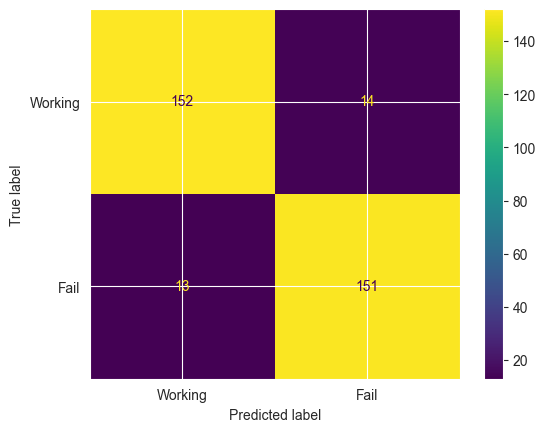

In [32]:
conf_matrix = confusion_matrix(y_test, y_test_pred) # computing the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Working', 'Fail']) # initializing the confusion matrix display
disp.plot() # plotting the confusion matrix

#### Classification Report

In [33]:
class_report = classification_report(y_test, y_test_pred) # computing the classification report
print("Classification Report: \n", class_report) # printing the classification report

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       166
           1       0.92      0.92      0.92       164

    accuracy                           0.92       330
   macro avg       0.92      0.92      0.92       330
weighted avg       0.92      0.92      0.92       330



In [34]:
y_test_pred = np.array(y_test_pred) # converting the predictions to a numpy array
accuracy = accuracy_score(y_test, y_test_pred) # computing the accuracy of the model
precision = precision_score(y_test, y_test_pred) # computing the precision of the model
recall = recall_score(y_test, y_test_pred) # computing the recall of the model
f1 = f1_score(y_test, y_test_pred) # computing the f1 score of the model

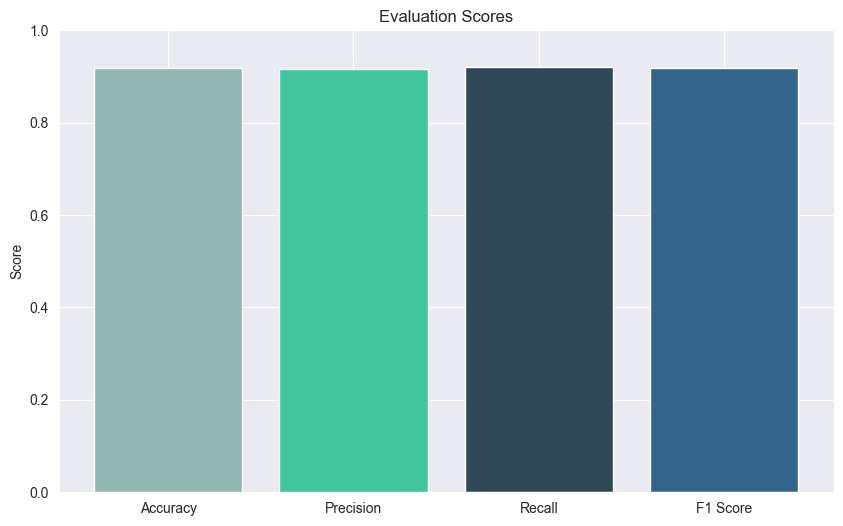

In [35]:
scores = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1} # storing the scores in a dictionary

color = ['#92B6B1', '#43C59E', '#2F4858', '#33658A'] # defining the colors for the plot
sns.set_style('darkgrid') # setting the style for the plot
plt.figure(figsize=(10, 6)) # setting the figure size
plt.bar(scores.keys(), scores.values(), color=color) # plotting the bar plot for the scores
plt.ylabel('Score') # setting the y-axis label
plt.ylim(0, 1)  # setting the range of values to be shown on the y-axis, which is between 0 and 1
plt.title('Evaluation Scores') # setting the title of the plot
plt.show() # displaying the plot